# Entraînement d'un CNN avec MLFlow, Pytorch et Lightning.

Dans ce notebook nous allons entrainer un CNN et logger ses paramètres, mesures et le modèle dans mlflow.   
Le serveur mlflow sera cette fois-ci un serveur distant et non en local.  

L'adresse du serveur distant est la suivant : http://68.219.107.45:5000/

!! IMPORTANT !! Avant toute chose, utilisez un GPU T4 comme processeur pour votre notebook.  
Aller en haut à droite sur le bouton "Connecter", cliquez sur la flèche.   
Dans "Modifier le type d'exécution" choisissez T4 GPU.  

Nous aurons besoin d'un GPU pour entrainer notre modèle.

### Installation et configuration

Nous installons pytorch et torchvision.

In [ ]:
!pip install torch torchvision

Nous installons MLFlow

In [ ]:
!pip install mlflow

### Données d'entrainement

Pour entrainer notre modèle nous allons utiliser le dataset intel pour la classification d'image de la plateforme Kaggle : https://www.kaggle.com/datasets/puneet6060/intel-image-classification

Vous pouvez soit le télécharger à la main depuis la plateforme et le place dans votre environnement.   
Soit utilisez le package python kaggle qui utilise l'api kaggle.  

Les cellules suivantes vous montrent comment télécharger le dataset avec le package kaggle.  

Installation du package kaggle

In [ ]:
!pip install kaggle

- Aller ensuite sur https://www.kaggle.com/  
- Créez vous un compte si ce n'est pas déjà fait.  
- Récupérez votre nom d'utilisateur.
- Dans votre espace utilisateur (vous pouvez y accéder en cliquant sur l'icône utilisateur en haut à droite) allez dans la section "Settings".   
- Descendez jusqu'à API.   
- Créez un nouveau token en cliquant sur "Create new token".  
- Récupérez le token créé.

Exécutez cette cellule en remplaçant !username! par votre username et !key! par votre token.

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"!username!","key":"!token!"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

Vous pouvez ensuite faire une recherche dans les datasets kaggle en ligne de commande.

In [ ]:
!kaggle datasets list -s intel-image-classification

ref                                                             title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
puneet6060/intel-image-classification                           Intel Image Classification                        346MB  2019-01-30 09:22:58          89944       1388  0.75             
kkhandekar/image-dataset                                        Image_Dataset                                     171MB  2020-06-28 22:44:13           1474         28  0.8125           
utkarshsaxenadn/intel-image-classifier-resblockcustom-model     Intel Image Classifier - ResBlock(Custom Model)   279KB  2022-10-02 02:48:22             18          8  1.0              
kutaykutlu/drowsiness-detection                                 Drowsi

Nous pouvons aussi utiliser kaggle depuis python et télécharger notre dataset en le dézippant.

In [ ]:
import kaggle

kaggle.api.authenticate() #utilise le fichier qu'on a créé 2 cellules au dessus.

kaggle.api.dataset_download_files('puneet6060/intel-image-classification', path='.', unzip=True)

Nous définissons les chemins vers les différents datasets

In [ ]:
## instanciate path
pred_folder =
test_folder =
train_folder =

-Récupérer le nom des classes disponibles et leur nombre.  
-Pour chaque dossier récupérer le nombre d'images contenues à l'intérieur pour chaque classe.  

### Traitement des données

Nous allons pouvoir maintenant entrainer notre CNN.

Tout d'abord importons les packages nécessaires.

In [ ]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
import torchvision.transforms as tt
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
%matplotlib inline

Nous allons ensuite loader nos données grâce aux ImageFolder et DataLoader.  

Tout d'abord nous allons récupérer la moyenne et l'écart type de données d'entrainement pour pouvoir ensuite normaliser nos données avec.

In [ ]:
train = ImageFolder(train_folder, transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
]))
train_dl = DataLoader(train, 64, shuffle=True, num_workers=3, pin_memory=True)

def get_mean_std(dl):
    sum_, squared_sum, batches = 0,0,0
    for data, _ in dl:
        sum_ += torch.mean(data, dim = ([0,2,3]))
        squared_sum += torch.mean(data**2, dim = ([0,2,3]))
        batches += 1

    mean = sum_/batches
    std = (squared_sum/batches - mean**2)**0.5
    return mean,std

mean, std = get_mean_std(train_dl)
mean, std

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


(tensor([0.4301, 0.4574, 0.4536]), tensor([0.2481, 0.2467, 0.2807]))

Nous définissons ensuite les transformations suivantes :

In [ ]:
stats = ((0.4301, 0.4574, 0.4536), (0.2481, 0.2467, 0.2807))
train_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.RandomHorizontalFlip(),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

test_transform = tt.Compose([
    tt.Resize(64),
    tt.RandomCrop(64),
    tt.ToTensor(),
    tt.Normalize(*stats,inplace=True)
])

Nous chargeons les données dans des datasets de train et de test avec ImageFolder tout en appliquant les transformations dédiées.

In [ ]:
train =
test =

Nous définissons une seed pour la reproctubilité des résultats.

In [ ]:
random_seed = 42
torch.manual_seed(random_seed);

Nous créons un dataset de validation.  
Pour rappel : https://towardsdatascience.com/train-validation-and-test-sets-72cb40cba9e7

In [ ]:
val_size = int(len(train) * 0.2)
train_size = len(train) - val_size

train_ds, val_ds = random_split(train, [train_size, val_size])
len(train_ds), len(val_ds)

(11228, 2806)

Nous définissons nos dataloaders à partir de nos datasets.

In [ ]:
batch_size = 128

# PyTorch data loaders
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
valid_dl = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_dl = DataLoader(test, batch_size*2, num_workers=2, pin_memory=True)

train_dl

Créez une fonction denormalize qui dénormalise nos images en appliquant les transformations inverses. Cad, multiplication par l'écart-type et ajout de la moyenne.

La fonctions prendra en entrée des images, les moyennes pour les différents channels de l'image ainsi que les écarts-types.

Transformez les moyennes et les écartypes en tenseur pytorch de taille (1,3,1,1).  

In [ ]:
def denormalize(images, means, stds):
    pass

Nous créons ensuite une fonction show_batch qui prend un dataloader et itère à travers celui-ci en répurant les images et les labels. La fonction affiche un carré de 12 par 12 du dataset grâce à un subplot matplotlib et la fonction make_grid.
Il ne faut pas oublier de dénormaliser les images avant de les afficher grâce à la fonction denormalize.

In [ ]:
def show_batch(dl):
    pass

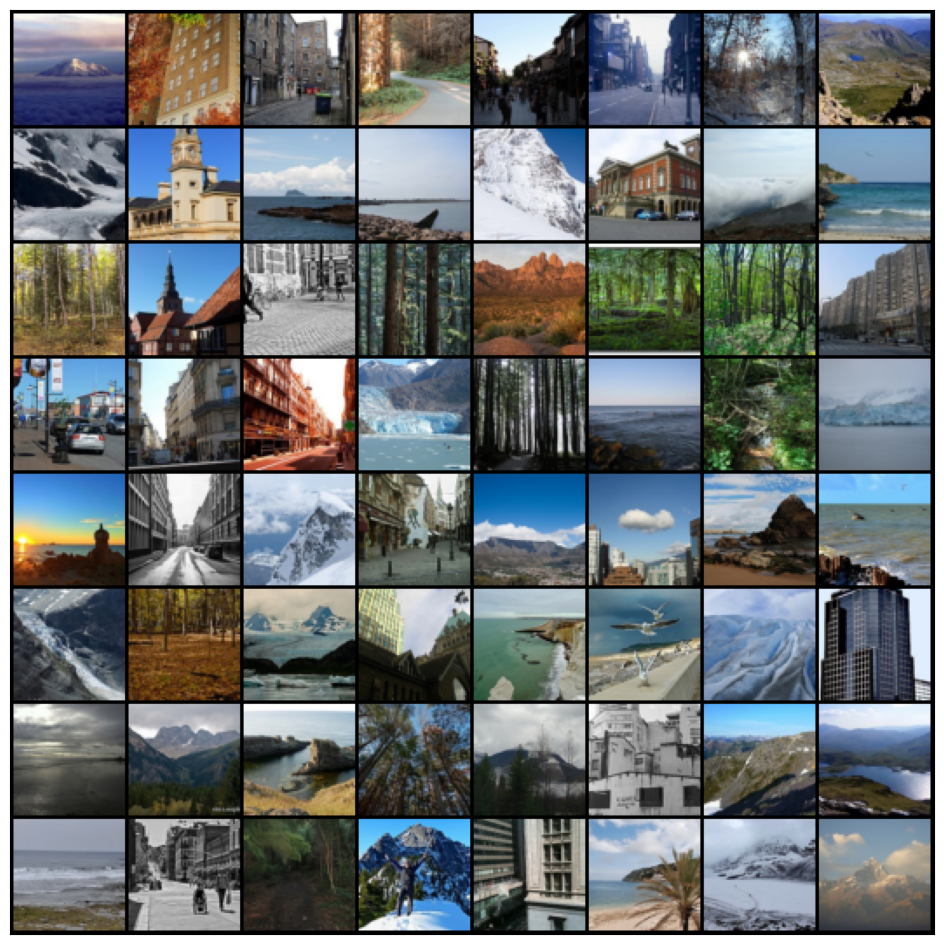

In [ ]:
show_batch(train_dl)

### CNN avec Pytorch lightning

Pour faciliter l'implémentation de notre CNN nous allons utiliser le package Pytorch lightning.  

Pytorch ligthning permet de simplifier l'écriture de RNN en Pytorch, un peu à la manière de Keras avec Tensorflow.

In [ ]:
!pip install lightning

Nous définissons une fonction conv_block correspondant aux layers de filtres de convolution de notre CNN.

En effet nous allons toujours appliquer ces 3 couches à la suite :
- nn.Conv2d
- nn.BatchNorm2d
- nn.ReLU

Créer une fonction conv_block qui prend en entrée le nombre de channels d'entrée et le nombre de channels de sortie.

La fonction prendra un autre paramètre booléen. Le paramètre pool qui appliquera une couche de max pooling si pool est à True. Par défaut ce paramètre sera à False.

Vous pouvez créer une liste avec toutes les couches et retourner un nn.Sequential avec tous la liste de layers.


In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    pass

Définir une fonction accuracy qui retourne l'accuracy en fonction des outputs passés et des labels.  

Vous pouvez utiliser les fonctions :
- torch.max : Pour récupérer selon la dimension 1 l'id de la classe avec la plus grosse probabilité et ensuite les comparer aux labels passés.
- torch.sum : Pour sommer le nombre d'éléments à True dans le tenseur.  
- .item() : pour récupérer le scalaire après la somme.
- torch.tensor : pour convertir le tout en tenseur.

On divisare la somme par le nombre de prédictions avant de transformer le tout en tenseur.

In [ ]:
def accuracy(outputs, labels):
    pass

In [ ]:
import lightning as L

class ResNet9Lighting(L.LightningModule):
  ## computationnal code
    def __init__(self, in_channels, num_classes, max_lr, weight_decay):
        super().__init__()

        self.conv1 = conv_block(in_channels, 64)
        self.conv2 = conv_block(64, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))

        self.conv3 = conv_block(128, 256, pool=True)
        self.conv4 = conv_block(256, 512, pool=True)
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))

        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1),
                                            nn.Flatten(),
                                            nn.Dropout(0.2),
                                            nn.Linear(512, num_classes))

        self.max_lr = max_lr
        self.weight_decay = weight_decay

    ## forward hook
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

    ## cofigure_optimizers L hook
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.max_lr, weight_decay=self.weight_decay)
        return optimizer

    ### training step hook
    def training_step(self, batch):
      images, labels = batch
      out = self(images)                  # Generate predictions
      loss = F.cross_entropy(out, labels) # Calculate loss
      self.log("train_loss", loss, on_epoch=True)
      return loss

    ### validation_step hook #à quoi sert le validation step
    def validation_step(self, val_batch):
        images, labels = val_batch
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        self.log('val_loss', loss)
        return {'val_loss': loss.detach(), 'val_acc': acc}


### MLFlow

Importez mlflow et définissez la tracking uri sur celle indiquée au début du notebook.  

__Important__ !!! Créez une experiment avec votre nom_prenom_cnn

Créez également une instance de MlflowClient avec la tracking uri

Reprenez la fonction config_exp définis dans le précédent notebook.

-Importez mflow.pytorch

-Paramétrez l'autolog de mlflow.pytorch.

-Instancier votre modèle et un L.Trainer avec comme accelerator "gpu" et un max d'epochs à 15.

-Configurer bien mlflow avec l'experiment à votre nom.

-Lancer un run en nommant bien celui-ci avec l'année, le mois, le jour, l'heure, la minute et la seconde comme précédement.   

-Dans le run vous pourrez éxécuter la fonction trainer.fit() avec les bons paramètres.

Utilisez la fonction print_auto_logged_info fournie dans la documentation pour afficher les paramètres et mesures du dernier run.